In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn import metrics

In [2]:
original_dataset = pd.read_csv('data/insurance.csv')
original_dataset.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
original_dataset.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [4]:
original_dataset.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


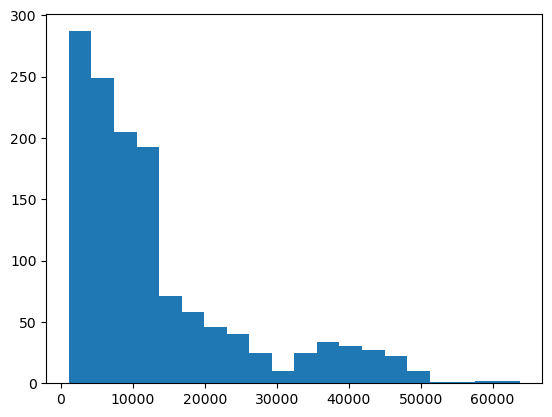

In [5]:
plt.hist(original_dataset['charges'], bins=20)
plt.show()

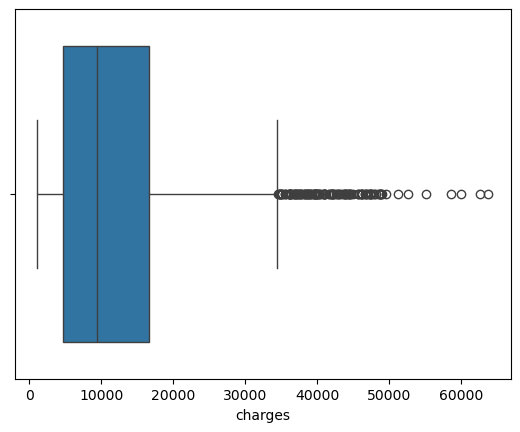

In [6]:
sns.boxplot(x=original_dataset['charges'])
plt.show()

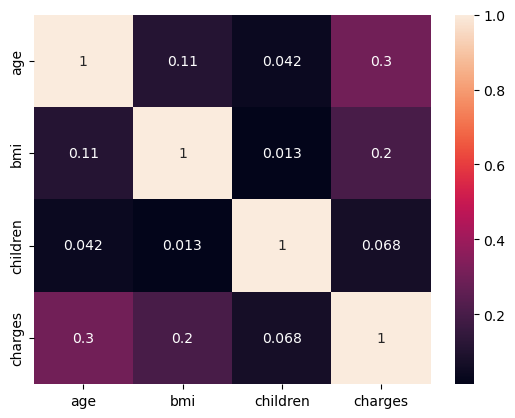

In [7]:
numerical_features = ['age', 'bmi', 'children', 'charges']
correlation_matrix = original_dataset[numerical_features].corr()
correlation_matrix

sns.heatmap(correlation_matrix, annot=True)
plt.show()

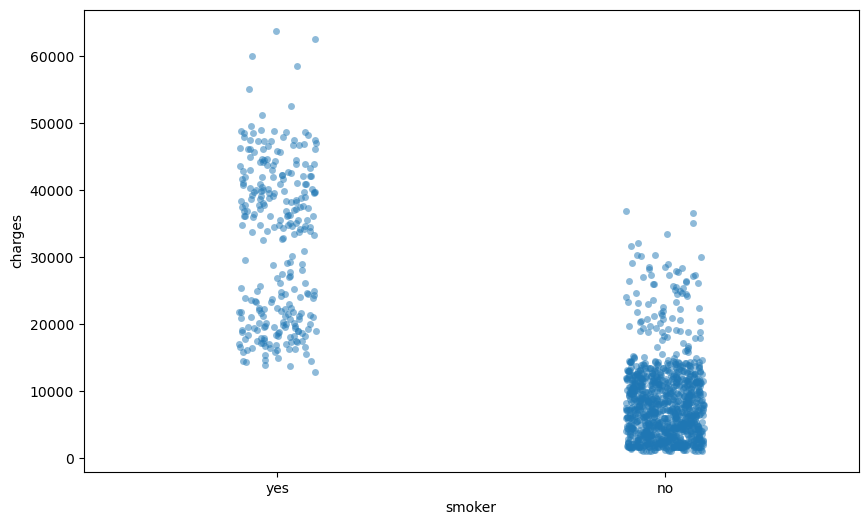

In [8]:
plt.figure(figsize=(10, 6))
sns.stripplot(data=original_dataset, x="smoker", y="charges", alpha=0.5)
plt.show()

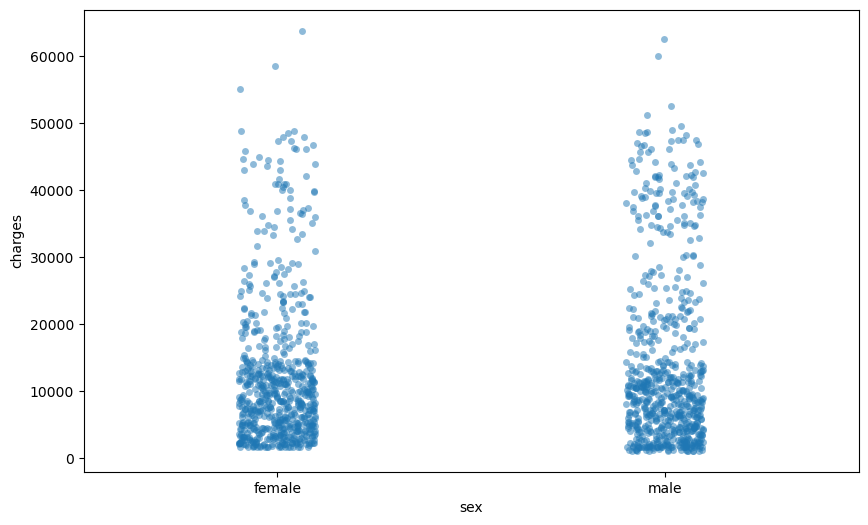

In [9]:
plt.figure(figsize=(10, 6))
sns.stripplot(data=original_dataset, x="sex", y="charges", alpha=0.5)
plt.show()

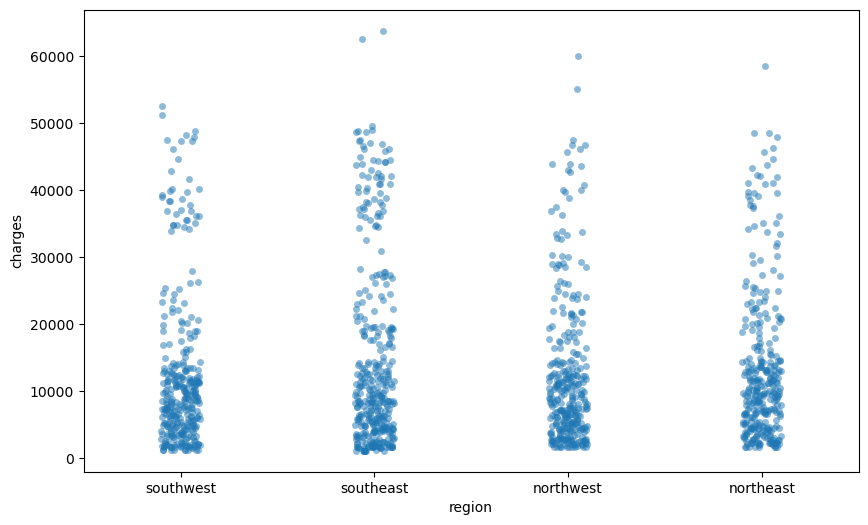

In [10]:
plt.figure(figsize=(10, 6))
sns.stripplot(data=original_dataset, x="region", y="charges", alpha=0.5)
plt.show()

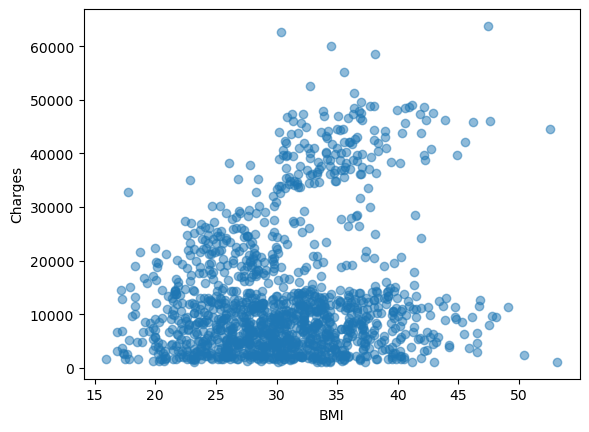

In [11]:
plt.scatter(original_dataset['bmi'], original_dataset['charges'], alpha=0.5)
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.show()

In [12]:
dataset = original_dataset.copy()
label_encoder = LabelEncoder()
binary_categorical_features = ['sex', 'smoker']
for column in binary_categorical_features:
    dataset[column] = label_encoder.fit_transform(dataset[column])
dataset.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,southwest,16884.92400
1,18,1,33.770,1,0,southeast,1725.55230
2,28,1,33.000,3,0,southeast,4449.46200
3,33,1,22.705,0,0,northwest,21984.47061
4,32,1,28.880,0,0,northwest,3866.85520


In [13]:
onehot_encoder = OneHotEncoder()
onehot_categorical_features = ['region']

# encode column region in the format region_sourthwest, region_southeast, region_northwest, region_northeast
onehot_encoded = onehot_encoder.fit_transform(dataset[onehot_categorical_features]).toarray()
onehot_encoded = pd.DataFrame(onehot_encoded, columns=onehot_encoder.get_feature_names_out(onehot_categorical_features))
dataset = pd.concat([dataset, onehot_encoded], axis=1)
dataset = dataset.drop(columns=onehot_categorical_features)
dataset.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0.0,0.0,0.0,1.0
1,18,1,33.770,1,0,1725.55230,0.0,0.0,1.0,0.0
2,28,1,33.000,3,0,4449.46200,0.0,0.0,1.0,0.0
3,33,1,22.705,0,0,21984.47061,0.0,1.0,0.0,0.0
4,32,1,28.880,0,0,3866.85520,0.0,1.0,0.0,0.0


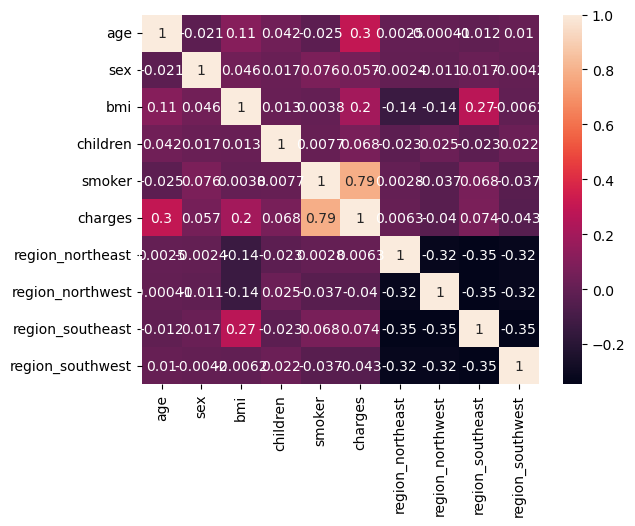

In [14]:
correlation_matrix = dataset.corr()
correlation_matrix

sns.heatmap(correlation_matrix, annot=True)
plt.show()

In [15]:
# independent_features = ['age', 'sex', 'bmi', 'children', 'smoker', 'region']
independent_features = ['age', 'sex', 'bmi', 'children', 'smoker'] + list(onehot_encoder.get_feature_names_out(onehot_categorical_features))
X = dataset[independent_features]
dependent_features = [
    'charges',
]
y = dataset[dependent_features]

scaler = StandardScaler()
X = scaler.fit_transform(X)


In [16]:
dataset['charge_group'] = pd.qcut(dataset['charges'], q=7, labels=False)

In [17]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=dataset["charge_group"], test_size=0.2, random_state=42)

In [31]:
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, y_train)

lin_reg_predictions = lin_reg_model.predict(X_test)

print('Mean squared error: %.2f' % metrics.mean_squared_error(y_test, lin_reg_predictions))
print('Coefficient of determination: %.2f' % metrics.r2_score(y_test, lin_reg_predictions))

Mean squared error: 30858005.36
Coefficient of determination: 0.80


In [19]:
X_test_original = scaler.inverse_transform(X_test)
X_columns = dataset[independent_features].columns
X_test_original = pd.DataFrame(X_test_original, columns=X_columns)

for column in binary_categorical_features:
    X_test_original[column] = label_encoder.inverse_transform(X_test_original[column].astype(int))

onehot_encoded_cols = onehot_encoder.get_feature_names_out(onehot_categorical_features)
X_test_original[onehot_categorical_features] = onehot_encoder.inverse_transform(X_test_original[onehot_encoded_cols].values)
X_test_original.drop(columns=onehot_encoded_cols, inplace=True)

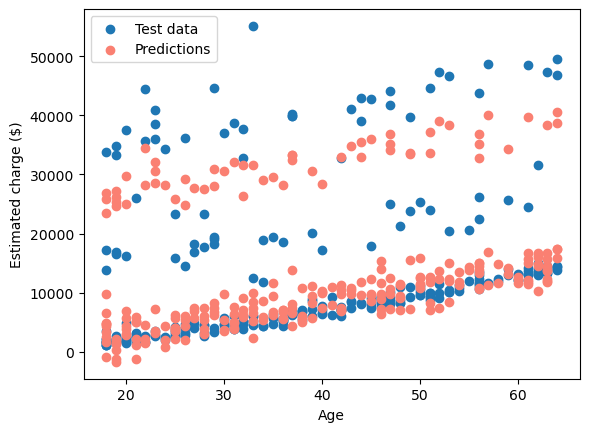

In [20]:
plt.scatter(X_test_original["age"], y_test, label="Test data")
plt.scatter(X_test_original["age"], lin_reg_predictions, color="salmon", label="Predictions")
plt.xlabel("Age")
plt.ylabel("Estimated charge ($)")
plt.legend()
plt.show()


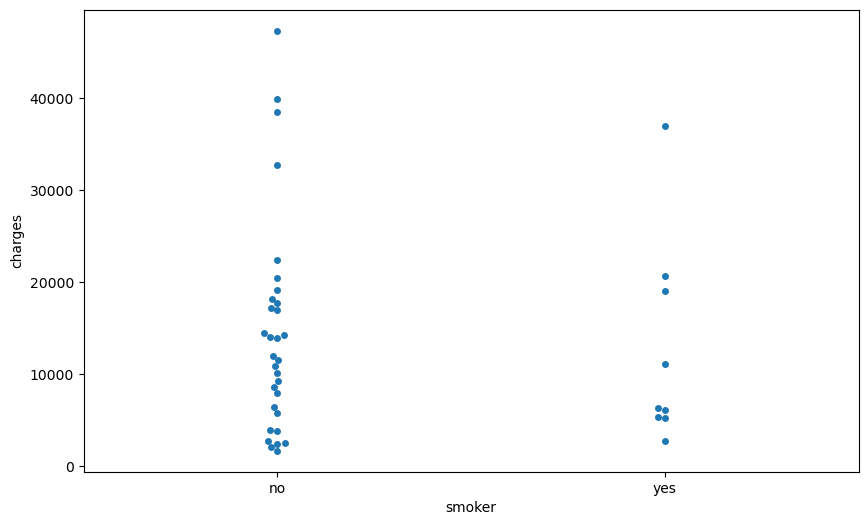

In [21]:
plt.figure(figsize=(10, 6))
sns.swarmplot(x=X_test_original["smoker"], y=y_test["charges"])
plt.show()

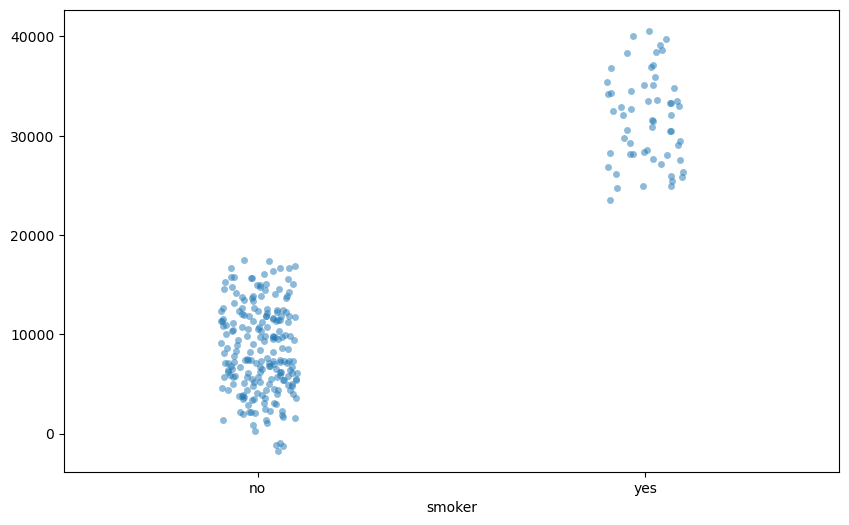

In [22]:
plt.figure(figsize=(10, 6))
sns.stripplot(x=X_test_original["smoker"], y=lin_reg_predictions[:, 0], alpha=0.5)
plt.show()

In [33]:
# gs_params = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [3, 5, 7],
#     'min_samples_split': [2, 3, 4]
# }

# rf_model = GridSearchCV(RandomForestRegressor(), gs_params, cv=5)

rf_model = RandomForestRegressor(n_estimators=50, max_depth=5, min_samples_split=2, random_state=42)
rf_model.fit(X_train, y_train.values.ravel())
# rf_model.best_params_
rf_predictions = rf_model.predict(X_test)

print('Mean squared error: %.2f' % metrics.mean_squared_error(y_test, rf_predictions))
print('Coefficient of determination: %.2f' % metrics.r2_score(y_test, rf_predictions))

Mean squared error: 15193717.86
Coefficient of determination: 0.90


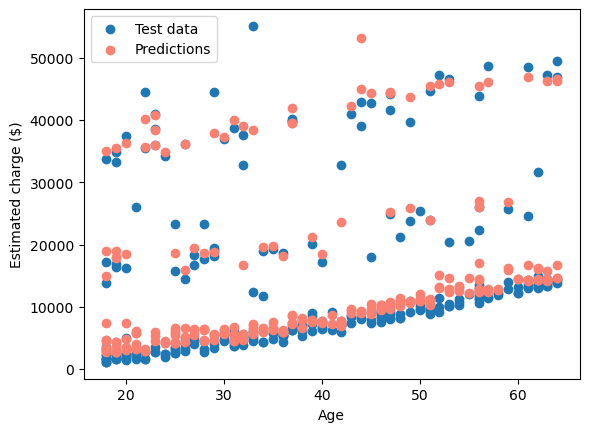

In [34]:
# X_columns = dataset[independent_features].columns
# X_test_original = pd.DataFrame(X_test, columns=X_columns)

plt.scatter(X_test_original["age"], y_test, label="Test data")
plt.scatter(X_test_original["age"], rf_predictions, color="salmon", label="Predictions")
plt.xlabel("Age")
plt.ylabel("Estimated charge ($)")
plt.legend()
plt.show()

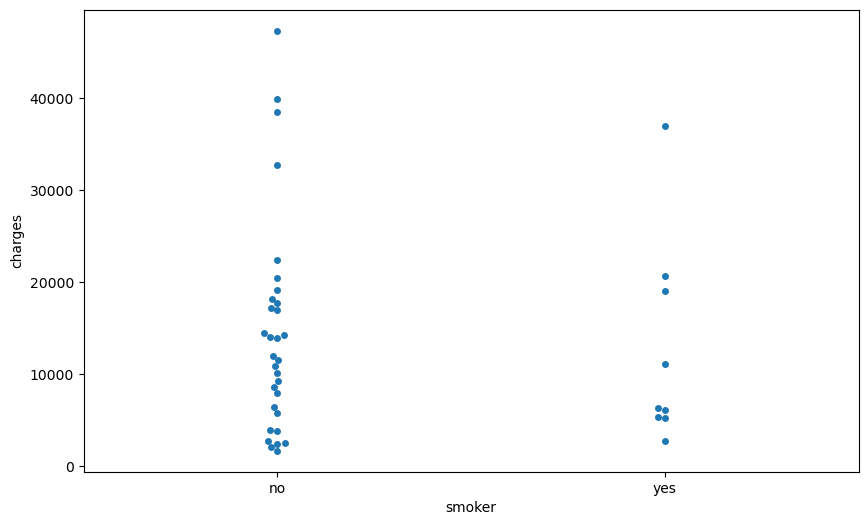

In [35]:
plt.figure(figsize=(10, 6))
sns.swarmplot(x=X_test_original["smoker"], y=y_test["charges"])
plt.show()

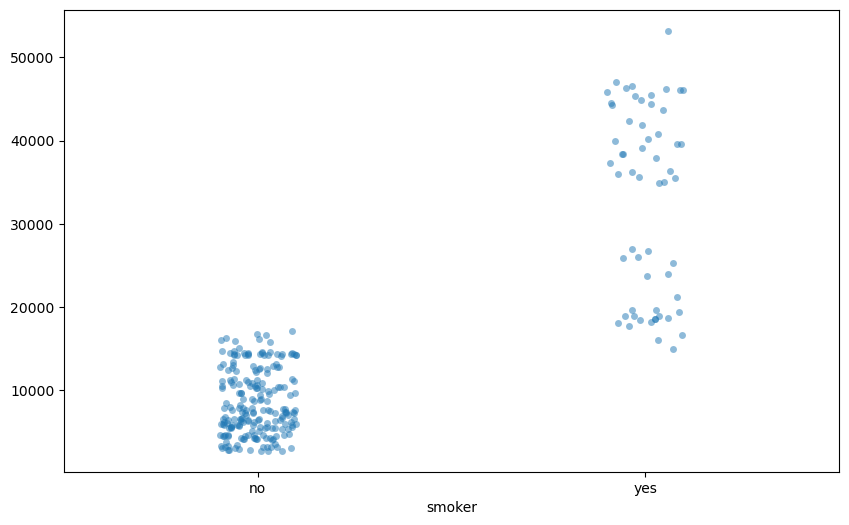

In [36]:
plt.figure(figsize=(10, 6))
sns.stripplot(x=X_test_original["smoker"], y=rf_predictions, alpha=0.5)
plt.show()